In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit



ro=8.0
#paper on MC used R0=8.5 kpc, using ro=8. as of now.
vo=220.

/home/nil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

Populating the interactive namespace from numpy and matplotlib


In [2]:
hdulist=fits.open('molecular_clouds/J_ApJ_834_57_table1.dat.gz.fits')
print (hdulist[1].columns)
aa=hdulist[1].data

ColDefs(
    name = 'Cloud'; format = 'I4'; disp = 'I4'; start = 1
    name = 'Ncomp'; format = 'I3'; disp = 'I3'; start = 6
    name = 'Npix'; format = 'I3'; disp = 'I3'; start = 10
    name = 'Area'; format = 'E12.6'; unit = 'deg2'; disp = 'E12.6'; start = 14
    name = 'GLON'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 27
    name = 'Sigb'; format = 'E12.6'; unit = 'deg'; disp = 'E12.6'; start = 41
    name = 'GLAT'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 54
    name = 'Sigl'; format = 'E12.6'; unit = 'deg'; disp = 'E12.6'; start = 68
    name = 'theta'; format = 'E13.6'; unit = 'deg'; disp = 'E13.6'; start = 81
    name = 'WCO'; format = 'E12.6'; unit = 'K.km/s'; disp = 'E12.6'; start = 95
    name = 'NH2'; format = 'E12.6'; unit = 'cm-2'; disp = 'E12.6'; start = 108
    name = 'Sigma'; format = 'E12.6'; unit = 'Msun/pc2'; disp = 'E12.6'; start = 121
    name = 'Vcent'; format = 'E13.6'; unit = 'km/s'; disp = 'E13.6'; start = 134
    name = 'SigV'; for

#To setup the orbits of the MCs, take (l,b,d) --> galactocentric rectangular coordinates

[R,vR,vT(,z,vz,phi)]

In [3]:
l=aa['GLON']
b=aa['GLAT']
#Near or far distance flag (0=near; 1=far) 
flag=aa['INF']
Dnear=aa['Dnear']
Dfar=aa['Dfar']
znear=aa['znear']
zfar=aa['zfar']
R_sph_gal=aa['Rgal']

In [4]:
def lbd_to_galcencyl(l,b,d,degree=True):
    xyz=bovy_coords.lbd_to_XYZ(l,b,d,degree=degree)
    Rphiz=bovy_coords.XYZ_to_galcencyl(xyz[:,0],xyz[:,1],xyz[:,2],Xsun=1.,Zsun=0.)
    
    return (Rphiz[:,0],Rphiz[:,1],Rphiz[:,2])

D=np.empty(len(l))
zfile=np.empty(len(l))

for ii in range(len(l)):
    if flag[ii] == 0 :
        D[ii]=Dnear[ii]
        zfile[ii]=znear[ii]
        
    else :
        D[ii]=Dfar[ii]
        zfile[ii]=zfar[ii]
        


R,phi,z= lbd_to_galcencyl(l,b,D)

R/=ro
z/=ro

print (min(phi),max(phi))

0.00034008007131385915 6.282280181831788


In [ ]:
print (max(np.abs(z*ro-zfile)))  #computed z and z from catalog match pretty well

In [6]:
#assign velocities, tangential velocity = vcirc, vR=vz=0
vT=np.empty(len(l))

for ii in range(len(l)):
    vT[ii]=vcirc(MWPotential2014,R[ii])

print (vT)

vR=np.zeros(len(l))
vz=np.zeros(len(l))


[1.00553195 1.00588521 1.00468541 ... 0.92576543 0.90723473 1.0217835 ]


In [7]:
#initialize orbits of the MCs and integrate them back 5 Gyrs and then integrete them forward for 5 Gyr
#as of now use MWPotential2014

t_age= np.linspace(0.,5.,1001)*u.Gyr/bovy_conversion.time_in_Gyr(vo,ro)
orbits= []

N=10 #len(l)

for ii in range(N):
    o= Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]]).flip() # flip flips the velocities for backwards integration
    
    o.integrate(t_age,MWPotential2014)
    orbits.append(o(t_age[-1]).flip()) 
    
    orbits[ii].integrate(t_age,MWPotential2014)

In [ ]:

orbits[9].plot(d1='x',d2='y',ro=ro,vo=vo)

orbits[9].plot(ro=ro,vo=vo)

In [ ]:
orbits[1].plot('k.',d1='ra',d2='dec',ro=ro,vo=vo)

In [8]:
#load the saved pickle file for converting apars to obs coords
with open('/home/nil/Dropbox/streamgap-pepper/pal5_64sampling.pkl','rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

In [9]:
print (sdf_pepper._timpact)

[  2.16342958   4.32685916   6.49028874   8.65371832  10.8171479
  12.98057748  15.14400706  17.30743664  19.47086622  21.6342958
  23.79772538  25.96115496  28.12458454  30.28801412  32.4514437
  34.61487328  36.77830286  38.94173244  41.10516202  43.2685916
  45.43202118  47.59545076  49.75888034  51.92230992  54.0857395
  56.24916908  58.41259866  60.57602824  62.73945782  64.9028874
  67.06631698  69.22974656  71.39317614  73.55660572  75.7200353
  77.88346488  80.04689446  82.21032404  84.37375362  86.5371832
  88.70061278  90.86404236  93.02747194  95.19090152  97.3543311
  99.51776068 101.68119026 103.84461984 106.00804942 108.171479
 110.33490858 112.49833816 114.66176774 116.82519732 118.9886269
 121.15205648 123.31548606 125.47891564 127.64234522 129.8057748
 131.96920438 134.13263396 136.29606354 138.45949311]


In [51]:
import simulate_streampepper

timpact= simulate_streampepper.parse_times('64sampling',5.)
#print (timpact)
#timpact = list(np.linspace(0.1,0.5,10)/bovy_conversion.time_in_Gyr(vo,ro))

#print (np.array(timpact)*bovy_conversion.time_in_Gyr(vo,ro))


t_age= np.linspace(0.,5.,1001)/bovy_conversion.time_in_Gyr(vo,ro)

pal5= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip()
pal5.integrate(t_age,MWPotential2014)
print (pal5.x(timpact[kk]),pal5.y(timpact[kk]))


#pal5_init=Orbit(pal5(t_age[-1]).flip()._orb.vxvv)

4.836493516627497 -6.857652982610022


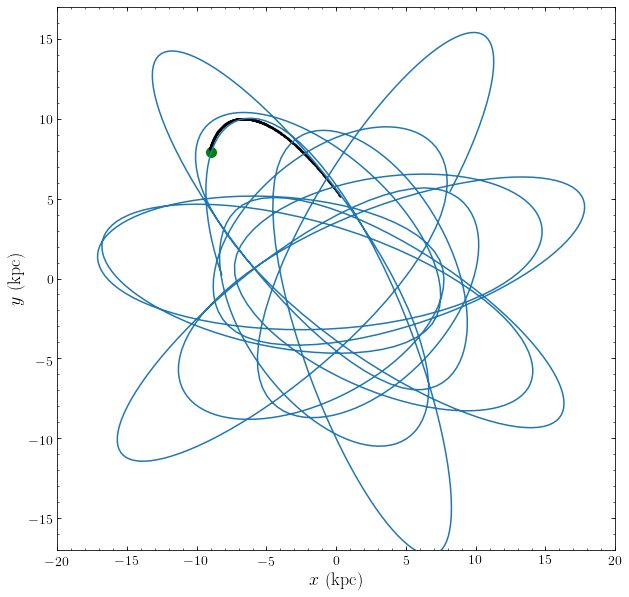

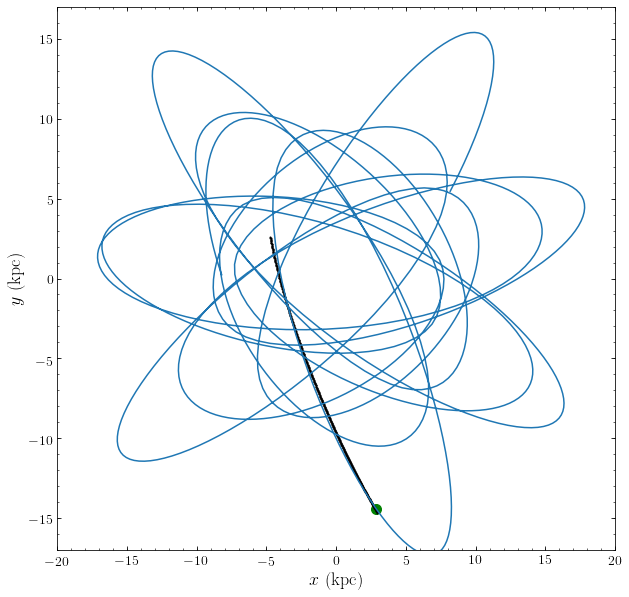

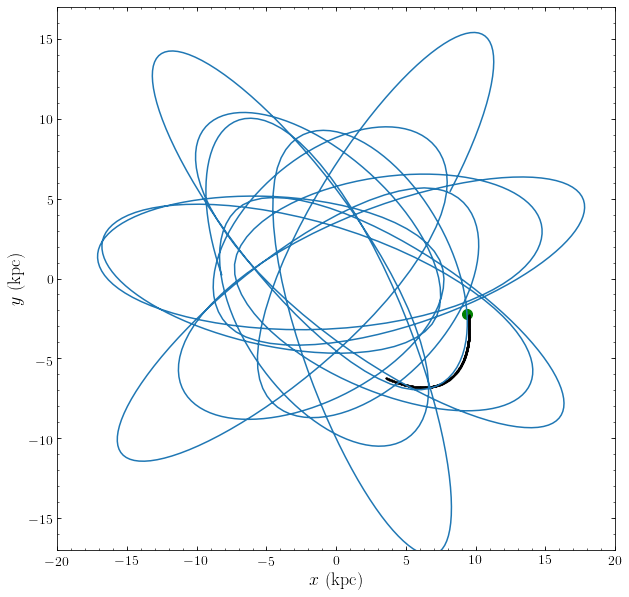

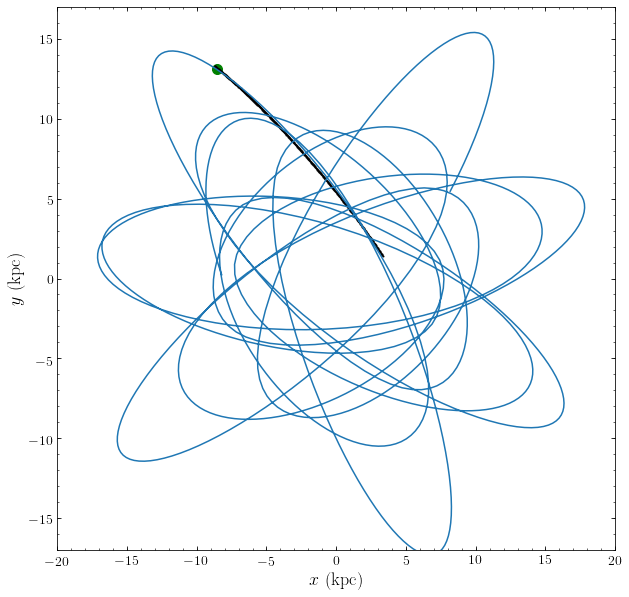

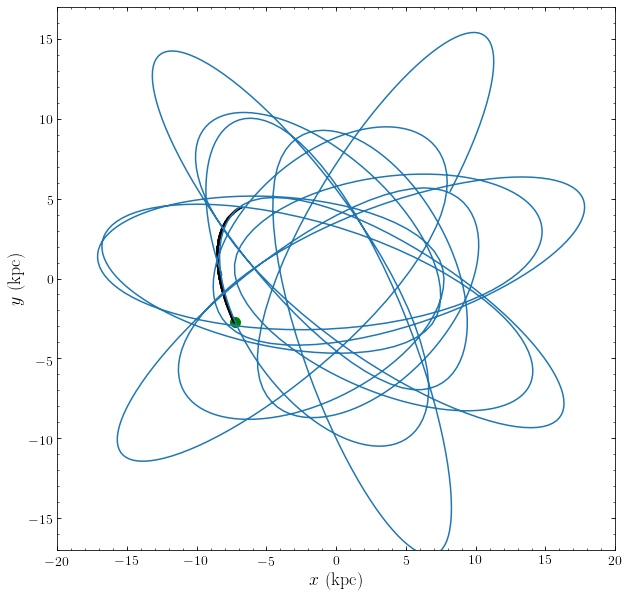

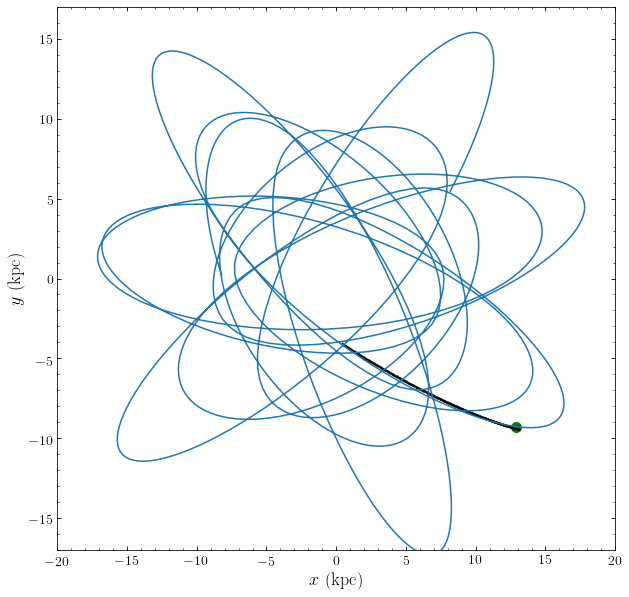

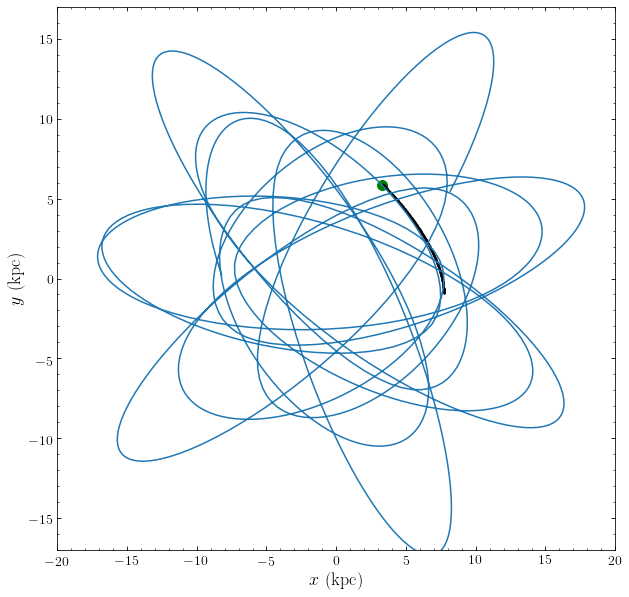

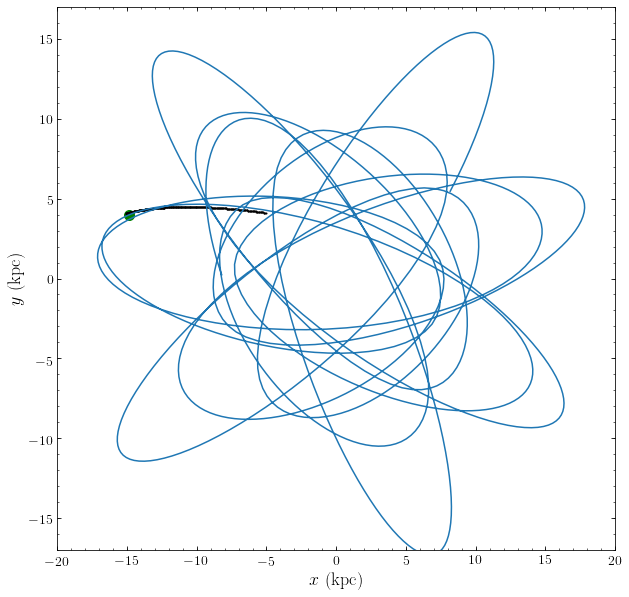

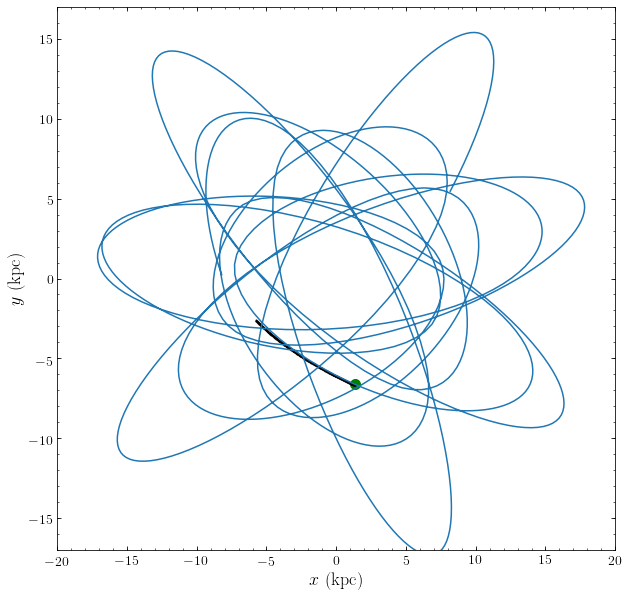

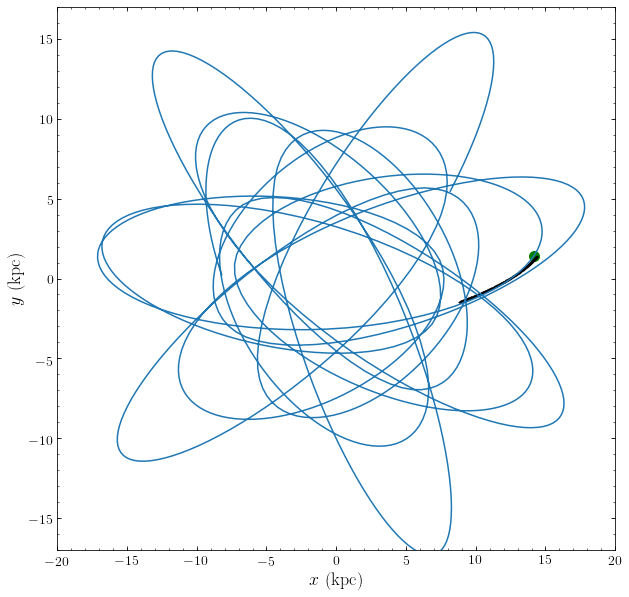

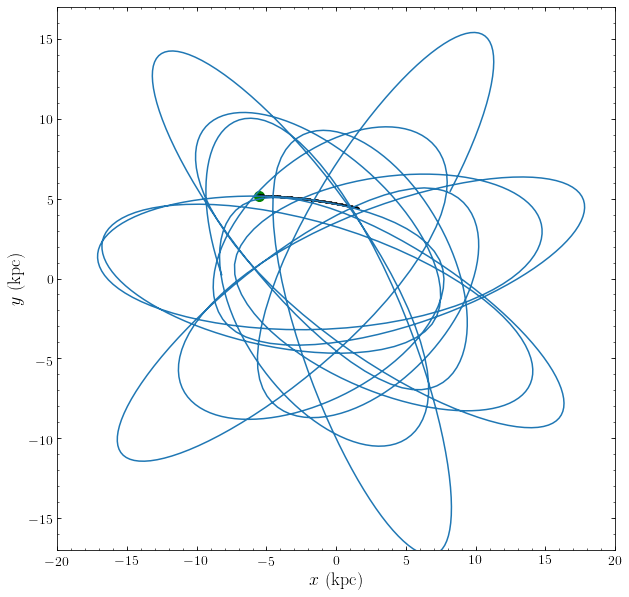

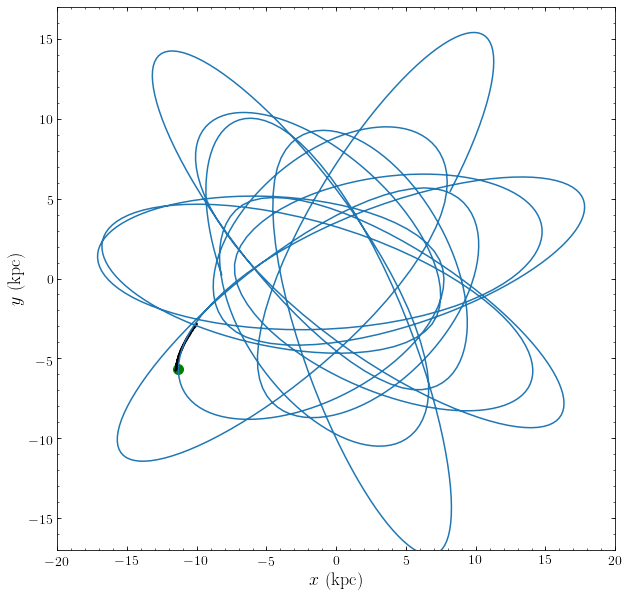

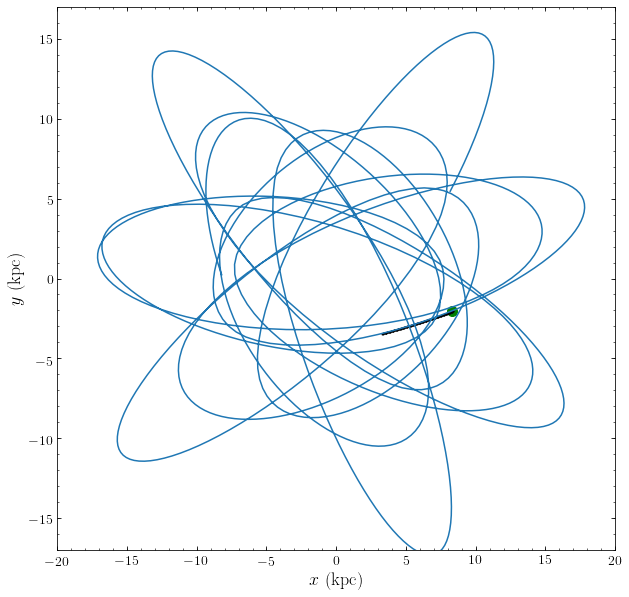

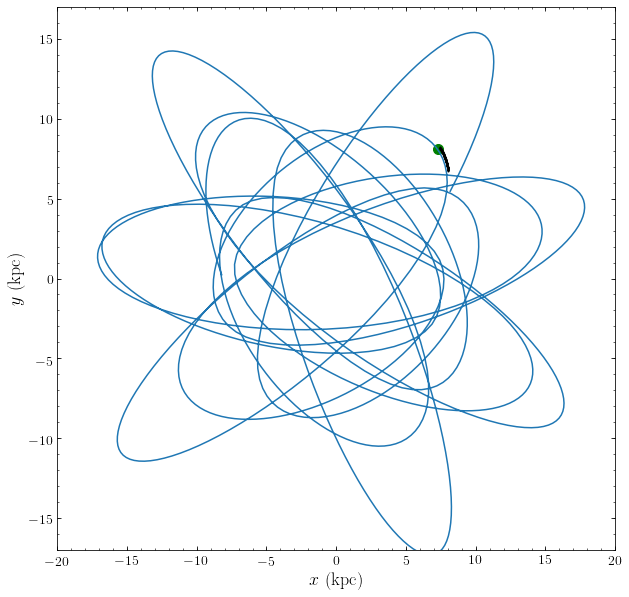

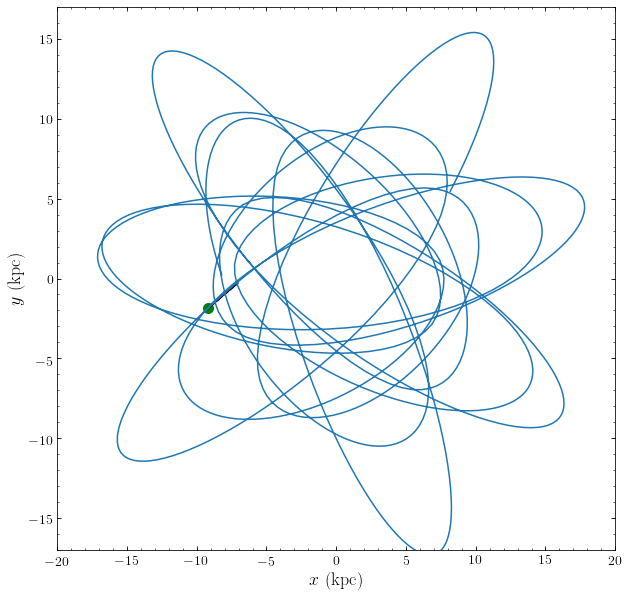

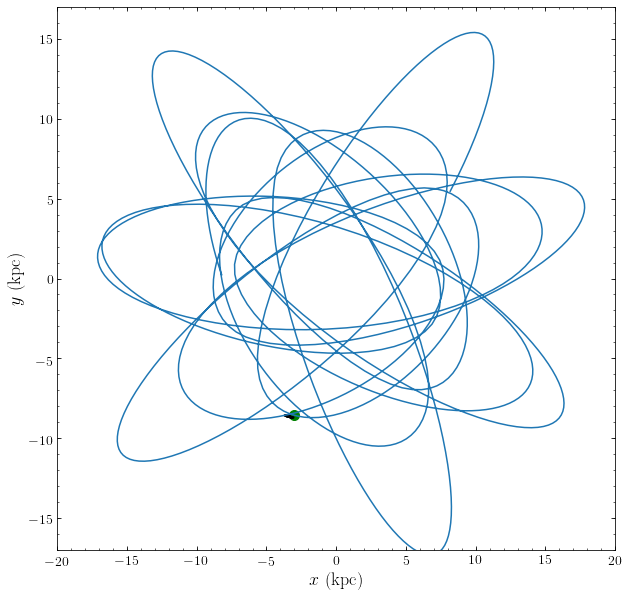

In [55]:
for kk in range(0,64,4):
    
    x=[]
    y=[]
    z=[]
    vx=[]
    vy=[]
    vz=[]
    
    a= sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedObsTrackXY
    apar_all=sdf_pepper._sgapdfs_coordtransform[timpact[kk]]._kick_interpolatedThetasTrack
    
    #lbd=bovy_coords.XYZ_to_lbd(a[:,0],a[:,1],a[:,2],degree=True)
    #radec_all=bovy_coords.lb_to_radec(lbd[:,0],lbd[:,1],degree=True) 
    #print (max(radec_all[:,0]))
    #radec_all[:,0][radec_all[:,0]>=180.]-=360.
         
    bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
    figsize(10,10)
    pal5.plot(d1='x',d2='y')
    #scatter(np.array(a[:,0])*ro,np.array(a[:,1])*ro,c='r',s=1)
    scatter(pal5.x(timpact[kk]),pal5.y(timpact[kk]),s=100,c='g')
    
    #at each timpact compute apar_max
    apar_max=sdf_smooth.length(tdisrupt=sdf_pepper._tdisrupt-timpact[kk])*sdf_pepper._length_factor
    
    #considering the stream until apar_max, store xyzvxvyvz 
    for ii in range(len(apar_all)):
        if apar_all[ii] <= apar_max : 
            x.append(a[:,0][ii])
            y.append(a[:,1][ii])
            z.append(a[:,2][ii])
            vx.append(a[:,3][ii])
            vy.append(a[:,4][ii])
            vz.append(a[:,5][ii])
    
    #lbd1=bovy_coords.XYZ_to_lbd(np.array(x),np.array(y),np.array(z),degree=True)
    #radec=bovy_coords.lb_to_radec(lbd1[:,0],lbd1[:,1],degree=True) 
    #print (radec[:,0])
    #radec[:,0][radec[:,0]>=180.]-=360.
    
    #print (radec[:,0])
    
    plt.scatter(np.array(x)*ro,np.array(y)*ro,c='k',s=1)
    plt.xlim(-20.,20.)
    plt.ylim(-17.,17.)
    plt.show()
    
    
    #x.append(a[:,0])
    #y.append(a[:,1])
    #z.append(a[:,2])
    
    
    #apar=apar_all[apar_all < apar_max]
    #print len(apar)
    
    #print (len(a[:,0]))

In [ ]:
print len(x[0])    
lbd=bovy_coords.XYZ_to_lbd(x[0],y[0],z[0],degree=True)

print len(lbd[:,0])

In [ ]:
print sdf_pepper.length(tdisrupt=sdf_pepper._tdisrupt-timpact[0])#*sdf_pepper._length_factor

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)

#pal5.plot(d1='x',d2='y')
#pal5.plot()

pal5.plot(d1='x',d2='y')

In [ ]:
import simulate_streampepper

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

timp= np.array(timpact)*bovy_conversion.time_in_Gyr(vo,ro)

print timp

pal5x= pal5.x(timp*u.Gyr)
pal5y=pal5.y(timp*u.Gyr)
pal5z=pal5.z(timp*u.Gyr)

print pal5x
#pal5_z=pal5.z(np.array(timpact)*u.Gyr)

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)


scatter(pal5x[0],pal5y[0])
scatter(x[0]*ro,y[0]*ro)
pal5.plot(d1='x',d2='y',overplot=True,c='k')


In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)


#scatter(pal5x[0],pal5y[0])
scatter(pal5x[0],pal5z[0])
scatter(x[0]*ro,z[0]*ro)
pal5.plot(d1='x',d2='z',overplot=True,c='k')

In [31]:
from astropy.coordinates import Angle
import astropy.units as u
a = [-20.0, 150.0, 350.0]

print (a)

a.wrap_at(360) # Wrap into range 0 to 360 degrees  

print (a)

[-20.0, 150.0, 350.0]


AttributeError: 'list' object has no attribute 'wrap_at'

In [14]:
aa=np.linspace(1,10,5)

print (aa)

aa[aa>7]+=1

print (aa)

[ 1.    3.25  5.5   7.75 10.  ]
[ 1.    3.25  5.5   8.75 11.  ]
